## NIH Dataset lassification for Pneumonia detection 

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn.model_selection as skl
from glob import glob
from itertools import chain
from numpy import sqrt
from numpy import argmax
from random import sample 
from skimage import io
from sklearn import metrics as skmetrics

In [11]:
import cv2
import pathlib
import pickle
import tensorflow_addons as tfa
import tensorflow as tf
from datetime import datetime
from PIL import Image
from tensorflow import expand_dims
from tensorflow.config.experimental import set_memory_growth, set_visible_devices,  list_logical_devices, list_physical_devices
#from tensorflow.data.experimental import AUTOTUNE
from tensorflow.math import l2_normalize
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
tf.__version__

'2.3.1'

In [13]:
def init_gpu():
    """Initialize GPU parameters to avoid cublas error
    TODO better description

    """
    gpus = list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                set_memory_growth(gpu, True)
                logical_gpus = list_logical_devices('GPU')
                print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

In [14]:
init_gpu()

Physical devices cannot be modified after being initialized


## Data Loading

In [15]:
## Loading data and adding a path column
df = pd.read_csv('./data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('.\\data','images', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', df.shape[0])
df['path'] = df['Image Index'].map(all_image_paths.get)
df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
6299,00001698_009.png,Atelectasis,9,1698,028Y,M,AP,2500,2048,0.168,0.168,NaN,.\data\images\00001698_009.png
96539,00025429_000.png,Atelectasis,0,25429,067Y,M,PA,2992,2991,0.143,0.143,NaN,.\data\images\00025429_000.png
8703,00002300_011.png,Infiltration,11,2300,081Y,F,AP,2500,2048,0.168,0.168,NaN,.\data\images\00002300_011.png


## Data Cleaning

In [16]:
# The column 'Unnamed: 11' is empty, let's drop it
df = df.drop('Unnamed: 11', axis=1)

# The image resolution is not a pertinent information for pneumonia cases modeling, so let's drop the last 4 columns
df = df.drop(['OriginalImage[Width', 
                               'Height]', 
                               'OriginalImagePixelSpacing[x', 
                               'y]'],
                               axis=1)

# Some patients have erronous ages
#TODO
#err_age = df[df['Patient Age'] > 100]
err_age  = None

In [17]:
# Let's do a 'hot-encoding' procedure for the categorical values of the 'Finding Labels' column to make the exploration easier
unique_findings = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
unique_findings = [x for x in unique_findings if len(x)>0]

print('All Labels ({}): {}'.format(len(unique_findings), unique_findings))
for c_label in unique_findings:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df.head(10)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path,Atelectasis,Cardiomegaly,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,.\data\images\00000001_000.png,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,.\data\images\00000001_001.png,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,.\data\images\00000001_002.png,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,081Y,M,PA,.\data\images\00000002_000.png,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,081Y,F,PA,.\data\images\00000003_000.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000003_001.png,Hernia,1,3,074Y,F,PA,.\data\images\00000003_001.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00000003_002.png,Hernia,2,3,075Y,F,PA,.\data\images\00000003_002.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00000003_003.png,Hernia|Infiltration,3,3,076Y,F,PA,.\data\images\00000003_003.png,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,00000003_004.png,Hernia,4,3,077Y,F,PA,.\data\images\00000003_004.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,00000003_005.png,Hernia,5,3,078Y,F,PA,.\data\images\00000003_005.png,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Splitting
We split the dataset into a training and a validation set in a 80:20 ratio.

In [18]:
train_df, test_df = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df['Pneumonia'])

In [19]:
print(train_df['Pneumonia'].sum()/len(train_df))

0.012062968248305387


In [20]:
print(test_df['Pneumonia'].sum()/len(test_df))

0.012085265786657154


The pneumonia occurences in the training dataframe is really low.
We modify the dataframe to obtain a 50% proportion of pneumonia case.

In [21]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [22]:
print(len(train_df))
train_df['Pneumonia'].sum()/len(train_df)

2164


0.5

For the validation dataset we'll keep the positive:negative cases ratio low enough to be close to the original whole dataset proportions (1.3%) but sufficient to give meaningful validation results during the training. So we'll choose a p:n ratio of 1:3.

In [23]:
p_inds = test_df[test_df.Pneumonia==1].index.tolist()
np_inds = test_df[test_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,3*len(p_inds))
test_df = test_df.loc[p_inds + np_sample]

In [24]:
print(len(test_df))
test_df['Pneumonia'].sum()/len(test_df)

1084


0.25

Let's plot some xrays before data augmentation to check that everything is ok.

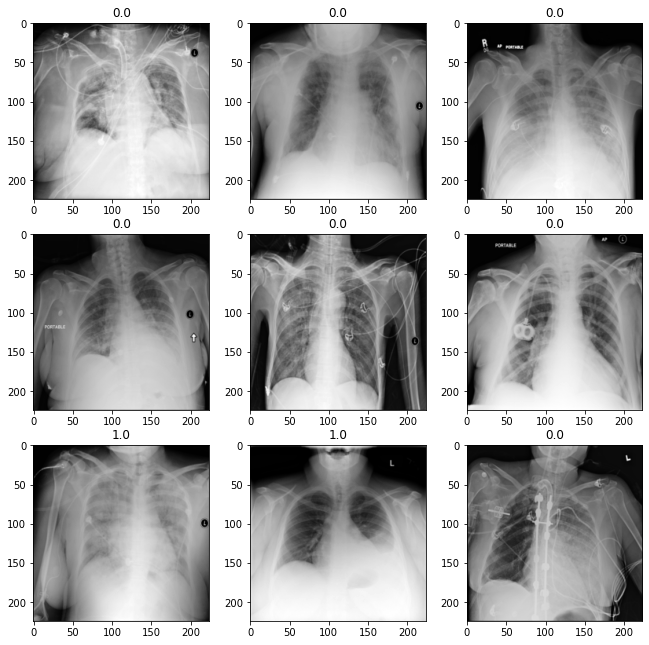

In [16]:
fig, m_axs = plt.subplots(3,3, figsize = (11, 11))
m_axs = m_axs.flatten()
imgs = train_df.path
ind=80512

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(df.iloc[ind]['Pneumonia'])
    ind=ind+1

In [17]:
# Statistics and Patient demographic data
# Notice that we will consider each xray as a different case

tnum_xrays = len(train_df)
tnum_uniq_pat = train_df['Patient ID'].nunique()
tnum_findings = len(unique_findings)
tnum_xrays_pneum = len(train_df[train_df['Pneumonia'] == 1])

#TODO tmean_age = train_df['Patient Age'].mean()
#TODO tstd_age = train_df['Patient Age'].std()
tratio_male = len(train_df[train_df['Patient Gender'] == 'M'])/tnum_xrays*100 
tratio_female = len(train_df[train_df['Patient Gender'] == 'F'])/tnum_xrays*100
tlist_viewposition = train_df['View Position'].unique()
tratio_viewpositionPA = len(train_df[train_df['View Position'] == 'PA'])/tnum_xrays*100 
tratio_viewpositionAP = len(train_df[train_df['View Position'] == 'AP'])/tnum_xrays*100 

In [18]:
print(
    #TODO 'Average of patients age :', tmean_age,"\n",
      #TODO 'Standard deviation of patients age :', tstd_age,"\n",
      'Proportion of Males:', tratio_male, "%\n", 
      'Proportion of Females:', tratio_female, "%\n",
      'Proportion of PA view position:',tratio_viewpositionPA, "%\n",
      'Proportion of AP view position:',tratio_viewpositionAP, "%\n\n",)

Proportion of Males: 57.208872458410355 %
 Proportion of Females: 42.791127541589645 %
 Proportion of PA view position: 53.04990757855823 %
 Proportion of AP view position: 46.950092421441774 %




In [19]:
# Statistics and Patient demographic data
# Notice that we will consider each xray as a different case

vnum_xrays = len(test_df)
vnum_uniq_pat = test_df['Patient ID'].nunique()
vnum_findings = len(unique_findings)
vnum_xrays_pneum = len(test_df[test_df['Pneumonia'] == 1])

#TODO vmean_age = test_df['Patient Age'].mean()
#TODO vstd_age = test_df['Patient Age'].std()
vratio_male = len(test_df[test_df['Patient Gender'] == 'M'])/vnum_xrays*100 
vratio_female = len(test_df[test_df['Patient Gender'] == 'F'])/vnum_xrays*100
vlist_viewposition = test_df['View Position'].unique()
vratio_viewpositionPA = len(test_df[test_df['View Position'] == 'PA'])/vnum_xrays*100 
vratio_viewpositionAP = len(test_df[test_df['View Position'] == 'AP'])/vnum_xrays*100

In [20]:
print(
    #TODO 'Average of patients age :', vmean_age,"\n",
      #TODO 'Standard deviation of patients age :', vstd_age,"\n",
      'Proportion of Males:', vratio_male, "%\n", 
      'Proportion of Females:', vratio_female, "%\n",
      'Proportion of PA view position:',vratio_viewpositionPA, "%\n",
      'Proportion of AP view position:',vratio_viewpositionAP, "%\n\n",)

Proportion of Males: 55.996309963099634 %
 Proportion of Females: 44.003690036900366 %
 Proportion of PA view position: 55.25830258302583 %
 Proportion of AP view position: 44.74169741697417 %




## Data augmentation

In [21]:
idg = ImageDataGenerator()

train_gen = idg.flow_from_dataframe(dataframe=train_df,
                                    directory=None,
                                    x_col = 'path',
                                    y_col = 'Pneumonia',
                                    class_mode = 'raw',
                                    target_size = (380, 380),
                                    batch_size = 32,
                                    validate_filenames= False)

Found 2164 non-validated image filenames.


In [37]:
val_idg = ImageDataGenerator()

val_gen = val_idg.flow_from_dataframe(dataframe=test_df, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'Pneumonia',
                                              class_mode = 'raw',
                                              target_size = (380, 380),
                                              batch_size = 32,
                                              validate_filenames= False) 

Found 1084 non-validated image filenames.


In [33]:
# Plotting some xrays from the training batch after data augmentation
t_x, t_y = next(train_gen)

fig, m_axs = plt.subplots(8, 5, figsize = (10, 10))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No-Pneumonia')
    c_ax.axis('off')

NameError: name 'train_gen' is not defined

The results of data augmentation is realistic and add some variety to the dataset that may provide more flexibility to the model.

In [24]:
data_augmentation = Sequential(
  [
      preprocessing.RandomRotation(factor=0.1,fill_mode='reflect',interpolation='bilinear'),
      preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
      preprocessing.RandomZoom(height_factor=(0.0, 0.1)),
      preprocessing.RandomWidth(factor=0.1),
      preprocessing.RandomHeight(factor=0.1),
#      preprocessing.RandomCrop(height=0.1, width=0.1),
#      preprocessing.RandomContrast(factor=(1,1.1)),
      
  ],
    name="img_augmentation",
)

In [25]:
def float_precision_strategy(precision = 'float32'):
    """ Define the float number policy. The use of mixed_float16 allows the
    use of tensor cores on NVidia GPUs and speed up calculations.

    Parameters
    ----------
    precision : str 'mixed_float16', 'float32'
        The precision strategy
    """
    # Use mixed precision and Nvidia tensor cores to speed up calculations
    # seems not to decrease acc # no noticeable increase in speed 
    policy = mixed_precision.Policy(precision) 
    mixed_precision.set_policy(policy)
    print('Compute dtype: %s' % policy.compute_dtype)
    print('Variable dtype: %s' % policy.variable_dtype)

In [26]:
float_precision_strategy(precision = 'mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2060, compute capability 7.5
Compute dtype: float16
Variable dtype: float32


## Model Building 



In [27]:
def build_base_model(img_width = 380, img_height = 380):
    """
    Instanciate the pretrained model, withimagenet weights, to build the costumized model.
    
    Parameters
    ----------
    img_width : int
    Width of the input image
    img_height : int
    Height of the input image
    augmentation : Boolean
    Boolean to use or not the data augmentation
    
    Returns:
    ----------
    base_model :
    Pretrained model that will be the base of teh costumized model
    """
    
    inputs = Input(shape=(img_width, img_height, 3))
    
    x = data_augmentation(inputs)    
    
    base_model = EfficientNetB4(include_top=False, input_tensor=x, drop_connect_rate=0.2, weights='imagenet')

    base_model.trainable = False
    return base_model

In [28]:
def unfreeze_layers(model, n = 0):
    """
    Instanciate the pretrained model, withimagenet weights, to build the costumized model.
    
    Parameters
    ----------
    model : 
    Model to unfreeze layers of
    n : int
    Number of the (last) layers to unfreeze
    bn_freeze : Boolean
    Freezing strategy concerning the batch normalization layers
    
    Returns
    ----------
    base_model :
    Pretrained model that will be the base of the costumized model
    """
    for layer in model.layers[-n:]:
    #TODO add other bn freezing strategies
    # if not isinstance(layer,BatchNormalization ):
        layer.trainable = True
    return model #TODO return model needed ? change this to a class

In [29]:
def custom_model(base_model):
    """
    #TODO to complete
    
    Parameters
    ----------
    base_model : 
    
    Returns
    ----------
    model :
    model adding the  customization layers to the base_model.
    """
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    model = Model(base_model.input, x)
    return model

In [30]:
def print_trainable_layers(model):
    """
    #TODO to complete
    
    Parameters
    ----------
    
    Returns
    ----------
    """
    print("Number of layers in the base model: ", len(model.layers))
    for layer in model.layers:
        print(layer.name, layer.trainable)

In [31]:
model = build_base_model(380, 380)
model = unfreeze_layers(model, n = 21)
model = custom_model(model)
print_trainable_layers(model)

Number of layers in the base model:  479
input_1 False
img_augmentation False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_pro

In [32]:
optimizer = Adam(lr=0.001)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [33]:
# Run a couple of epochs
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2)

Epoch 1/2
68/68 [==============================] - 30s 444ms/step - loss: 0.7020 - binary_accuracy: 0.5883 - val_loss: 0.8875 - val_binary_accuracy: 0.2500
Epoch 2/2
68/68 [==============================] - 27s 398ms/step - loss: 0.6486 - binary_accuracy: 0.6206 - val_loss: 0.9626 - val_binary_accuracy: 0.2500


In [34]:
# Print log
#TODO try tensorboard
#logdir = ("./logs/scalars/" + "_" + datetime.now().strftime("%Y%m%d-%H%M%S"))  # create a folder for each model.
#tensorboard_callback = TensorBoard(log_dir=logdir)
# use tensorboard --logdir logs/scalars in your command line to startup tensorboard with the correct logs

# Saves best weights according to the value monitored
weight_path="weights.hdf5"

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'max',                           
                             save_weights_only = True)

# Stops if the value monitored doesn't improve after 'patience' epochs 
early = EarlyStopping(monitor= 'binary_accuracy', 
                      mode= 'max',
                      restore_best_weights=True,                      
                      min_delta=0.01,
                      patience=10)

reduce_lr = ReduceLROnPlateau(monitor='binary_accuracy', min_delta=0.01, factor=0.8, patience=5, mode='max')

callbacks_list = [checkpoint, early, reduce_lr]

In [35]:
# Load weights
try:
    model.load_weights(weight_path)
except OSError:
    print("the file doesn't exist yet")
except ValueError :                               
    print('Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.')

Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.


### Training

In [40]:
epochs = 10

#with tf.device("GPU:0"):
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks = callbacks_list, 
    workers=4,
)

Epoch 1/10
68/68 [==============================] - ETA: 0s - loss: 0.1854 - binary_accuracy: 0.9247
Epoch 00001: binary_accuracy did not improve from 0.92606
68/68 [==============================] - 29s 429ms/step - loss: 0.1854 - binary_accuracy: 0.9247 - val_loss: 2.2284 - val_binary_accuracy: 0.2500
Epoch 2/10
68/68 [==============================] - ETA: 0s - loss: 0.1903 - binary_accuracy: 0.9205
Epoch 00002: binary_accuracy did not improve from 0.92606
68/68 [==============================] - 29s 430ms/step - loss: 0.1903 - binary_accuracy: 0.9205 - val_loss: 2.2088 - val_binary_accuracy: 0.2500
Epoch 3/10
68/68 [==============================] - ETA: 0s - loss: 0.1844 - binary_accuracy: 0.9201
Epoch 00003: binary_accuracy did not improve from 0.92606
68/68 [==============================] - 29s 428ms/step - loss: 0.1844 - binary_accuracy: 0.9201 - val_loss: 3.1772 - val_binary_accuracy: 0.2500
Epoch 4/10
68/68 [==============================] - ETA: 0s - loss: 0.1611 - binary_a

In [41]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss", color="orange")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss", color="red")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc", color="skyblue")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc", color="blue")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

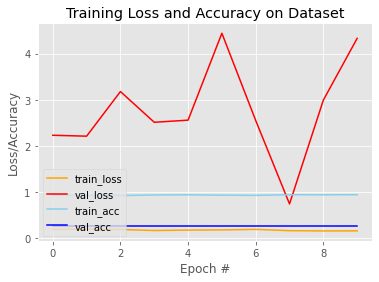

In [42]:
plot_history(history)

## Model's performance assessment and threshold tuning
After building the model and training it, we can now choose a good probability threshold to convert probabilities to class (Pneumoniia/non pneumonia). Code used here comes from : https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [8]:
## Making some predictions to assess model's overall performance

from tensorflow.keras.models import model_from_json

model_name = "my_model.json"
weight_path = "weights.hdf5"

with open(model_name, "r") as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)
model.load_weights(weight_path)

model.trainable = False

In [25]:
val_idg = ImageDataGenerator()
val_gen = val_idg.flow_from_dataframe(dataframe=test_df, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'Pneumonia',
                                              class_mode = 'raw',
                                              target_size = (380, 380),
                                              batch_size = 1024,
                                              validate_filenames= False) 
v_x, v_y = next(val_gen)

Found 1084 non-validated image filenames.


In [27]:
pred_y = model.predict(v_x, batch_size = 32, verbose = True)

32/32 [==============================] - 8s 238ms/step


### Sensitivity/Specificity balance (ROC curve)

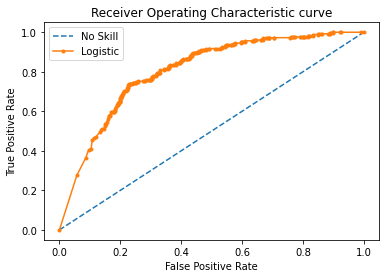

In [28]:
# calculating the true-positive rate and false-positive rate 
# for the predictions using a set of thresholds to create a ROC Curve plot.

fpr, tpr, thresholds = skmetrics.roc_curve(v_y, pred_y)  

# plotting the roc curve

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend()
plt.show()

In [29]:
# Calculating the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locating the index/threshold with the largest g-mean
# the optimal balance between false positive and true positive rates
ix = argmax(gmeans)
gmean_thresh = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.885742, G-Mean=0.754


### Precision/Recall balance 

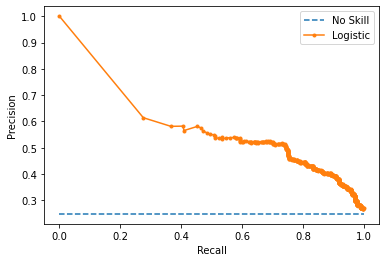

In [30]:
# Calculating pr-curve

precision, recall, thresholds = skmetrics.precision_recall_curve(v_y, pred_y)

# Plotting the pr-curve for the model

no_skill = len(v_y[v_y==1]) / len(v_y)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [31]:
# Calculating F score

fscore = (2 * precision * recall) / (precision + recall)

# Locating the index of the largest f score

ix = argmax(fscore)
f_thresh = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.902832, F-Score=0.607


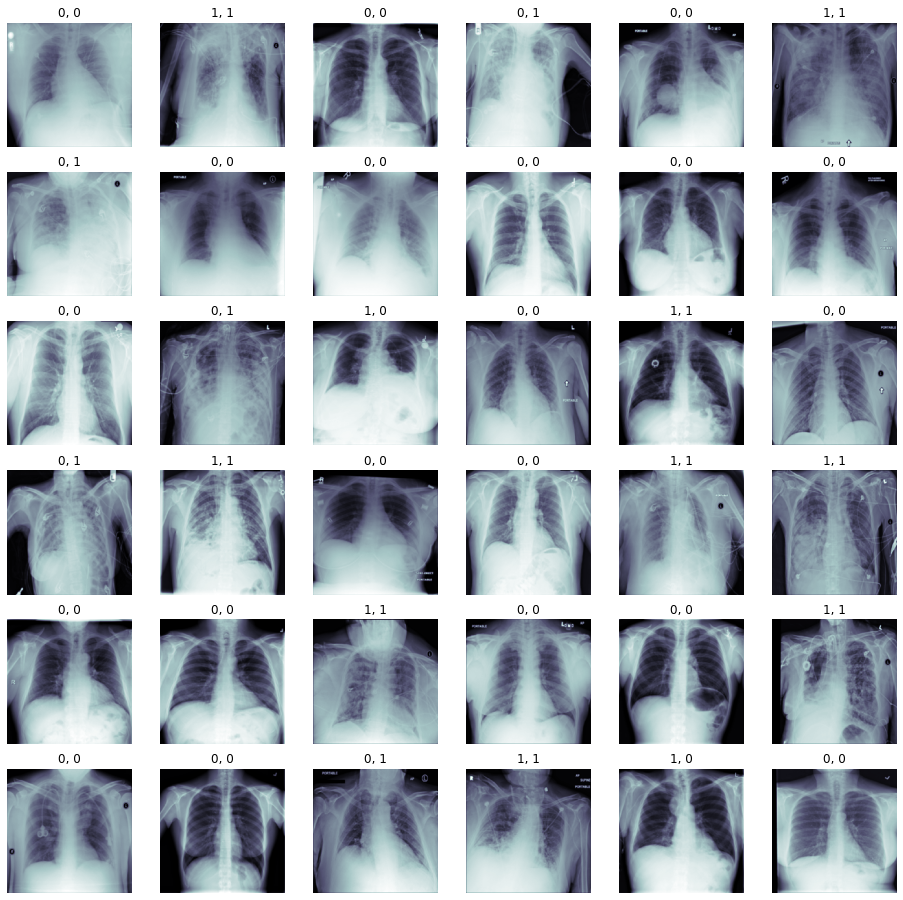

In [32]:
# Plotting some examples of true vs. predicted with the largest g-mean threshold: 

thresh = f_thresh
fig, m_axs = plt.subplots(6, 6, figsize = (16, 16))
i = 0

for (c_x, c_y, c_ax) in zip(v_x[0:36], v_y[0:36], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_y[i] > thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_y[i] > thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [54]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)